In [6]:
# import matplotlib as mpl
# mpl.use('Agg')
%matplotlib inline


import networkx as nx
import numpy as np
import random
import pandas as pd
import math
from copy import copy
from collections import defaultdict, Counter
from matplotlib import pyplot as plt
from itertools import combinations
from tqdm import tqdm
from joblib import Parallel, delayed

from graph_generator import grid_2d, add_p_and_delta
from simulations import sample_graph_from_infection, simulate_IC, make_input
from plot_utils import plot_snapshot
from core import accuracy_for_nodes, experiment_multiple_rounds, normalize_mu, generate_sufficient_stats
from utils import generalized_jaccard_similarity

In [ ]:
# seed = 123456
# random.seed(seed)
# np.random.seed(seed)

In [7]:
infp = 0.7
g = grid_2d(10)
g = add_p_and_delta(g, infp, 1)
pos = {n: np.array(n) for n in g.nodes()}

In [8]:
def infeciton_time2weight(ts):
    times = np.array(list(ts.values()))
    times = times[(np.invert(np.isinf(times)))]
    max_val = np.max(times)
    return {n: (max_val - t if not np.isinf(t) else 0) for n, t in ts.items()}
    

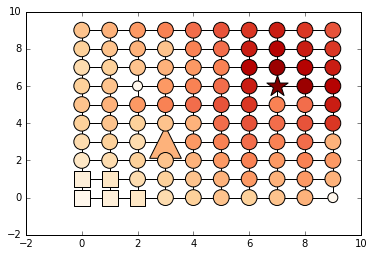

In [9]:
source, obs_nodes, infection_times, tree = make_input(g, infp, 0.05, sampling_method='late_nodes')

node2weight = infeciton_time2weight(infection_times)

plot_snapshot(g, pos, node2weight, 
              query_node=(3, 3),
              source_node=source,
              queried_nodes=obs_nodes)

In [7]:
N = 250
# list of list of (source, times, tree)
stats = Parallel(n_jobs=-1)(delayed(generate_sufficient_stats)(g) for i in range(N))

In [8]:
# dict: node as source -> 2d matrix (infection time, node)
times_by_source = defaultdict(list)
for stat in stats:
    for s, times, _ in stat:
        times_array = np.array([times[n] for n in g.nodes_iter()])
        times_by_source[s].append(times_array)
times_by_source = {s: np.array(times2d)
                   for s, times2d in times_by_source.items()}

In [9]:
source2nodeid_counter = defaultdict(dict)
N = g.number_of_nodes()
for src, times in tqdm(times_by_source.items()):
    for i in range(N):
        source2nodeid_counter[src][i] = Counter(times[:, i])

100%|██████████| 100/100 [00:00<00:00, 141.62it/s]


In [10]:
if True:
    import pickle as pkl
    pkl.dump(source2nodeid_counter, open('outputs/source2nodeid_counter.pkl', 'wb'))

In [11]:
RANDOM = 'random'
MAX_MU = 'max_mu'
MIN_CONSENSUS = 'min_consensus'

In [12]:
from query_strategy import consensus_score

In [20]:
def mwu(g, source, obs_nodes, infection_times,
        times_by_source, 
        source2nodeid_counter,
        epsilon, 
        check_neighbor_threshold=0.1,
        query_selection_method=MAX_MU,
        debug=False, plot=False,
        inspect_mu=False,
        max_plots=9):
    """
    times_by_source: sufficient statistics from each node (precomputed)
    infection_times: observation
    """
    mu_of_source = []
    ### debugging START    
    if plot:
        pos = {n: np.array(n) for n in g.nodes()}
        ncols = 2
        nrows = math.ceil((max_plots) / ncols)
        width = 12
        height = int(width * nrows / ncols)
        fig, ax = plt.subplots(nrows, ncols,
                               sharex=True, sharey=True,
                               figsize=(width, height))
        node2weight = infeciton_time2weight(infection_times)
        plot_snapshot(g, pos, node2weight, source_node=source, queried_nodes=obs_nodes, ax=ax[0, 0])
        ax[0, 0].set_title('ground truth')
    ### debugging END
        
    node2id = {n: i for i, n in enumerate(g.nodes_iter())}
    mu = {n: 1 for n in g.nodes()}
    mu = normalize_mu(mu)
    mu_of_source.append(mu[source])

    query_count = 0
    queried_nodes = set()

    # using the observations
    for q in sorted(obs_nodes, key=lambda n: infection_times[n]):
        outcome = infection_times[q]
        acc = accuracy_for_nodes(q, outcome, times_by_source, node2id)
        for n, ac in acc.items():
            mu[n] *= np.power(1-epsilon, 1-ac)
        mu = normalize_mu(mu)
        queried_nodes.add(q)

    ### debugging START
    if debug:
        print_nodes_by_mu(g, mu, source)
        
    if plot and max_plots >= 1:
        i, j = 0, 1
                
        plot_snapshot(g, pos, mu, source_node=source, queried_nodes=obs_nodes, ax=ax[i, j])
        ax[i, j].set_title('using observation')
    ### debugging END
        
    max_iter = float('inf')
    iter_i = 0

    all_nodes = set(g.nodes())
    while iter_i < max_iter:
        iter_i += 1
        queryable = list(all_nodes - queried_nodes)
        if len(queryable) == 0:
            if debug:
                print('no more nodes to query')
            break
        if query_selection_method == RANDOM:
            q = random.choice(queryable)
        elif query_selection_method == MAX_MU:
            q = max(all_nodes - queried_nodes, key=lambda n: mu[n])
        elif query_selection_method == MIN_CONSENSUS:
            q = min(queryable,
                    key=lambda cq: consensus_score(cq, times_by_source, mu, node2id,
                                                   source2nodeid_counter))
        else:
            raise ValueEerror('available query methods are {}'.format(RANDOM, MAX_MU, MIN_CONSENSUS))
    
        queried_nodes.add(q)        
        query_count += 1

                ### debugging START
        if plot and iter_i+2 <= max_plots:
            i, j = int((iter_i+1) / ncols), (iter_i+1) % ncols
            plot_snapshot(g, pos, mu, query_node=q, source_node=source, queried_nodes=obs_nodes, ax=ax[i, j])
            ax[i, j].set_title('iter_i={}'.format(iter_i))                        
        ### debugging END

        
        if debug:
            print('query {}'.format(q))

        # if some node has very large mu
        # query its neighbors
        if not inspect_mu and max(mu.values()) > check_neighbor_threshold:
            s = max(mu, key=mu.__getitem__)
            if s not in queried_nodes:
                query_count += 1
                queried_nodes.add(s)
                
            is_source = np.all(list(map(lambda u: infection_times[s] < infection_times[u],
                                        g.neighbors(s))))
            unqueried_nodes = set(filter(lambda u: u not in queried_nodes, g.neighbors(s)))
            query_count += len(unqueried_nodes)
            queried_nodes |= unqueried_nodes
            if is_source:
                if debug:
                    print('**Found source')
                    print('used {} queries'.format(query_count))
                assert source == s
                break

        outcome = infection_times[q]
        acc = accuracy_for_nodes(q, outcome, times_by_source, node2id)
        for n, ac in acc.items():
            mu[n] *= np.power(1-epsilon, 1-ac)

        mu = normalize_mu(mu)    
        
        mu_of_source.append(mu[source])
        if debug:        
            print('iteration: {}'.format(iter_i))
            print_nodes_by_mu(g, mu, source)

    return query_count, mu_of_source

95
1 loop, best of 1: 19.7 s per loop


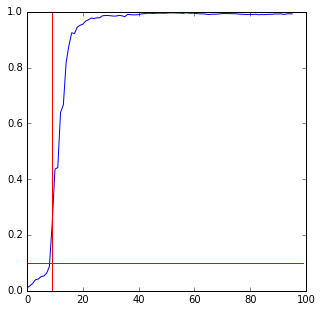

In [28]:
# demo of how mu(source increases)

source, obs_nodes, infection_times, tree = make_input(g, infp=0.7,
                                                      fraction=0.05, sampling_method='late_nodes')
query_count, mu_of_source = mwu(g, source, obs_nodes, infection_times, 
                                times_by_source, source2nodeid_counter,
                                epsilon=0.7,
                                query_selection_method=MIN_CONSENSUS,
                                check_neighbor_threshold=0.1,
                                inspect_mu=True,
                                debug=False, 
                                plot=True,
                                max_plots=6)
print(query_count)
plt.clf()
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(mu_of_source)
ax.plot([0.1]*100, 'r')

idx = np.nonzero(np.array(mu_of_source) > 0.1)[0]
if len(idx) > 0:
    half_value = idx[0]
    ax.plot([half_value]*20, np.linspace(0, 1.0, 20), 'r')

1 loop, best of 1: 751 ms per loop


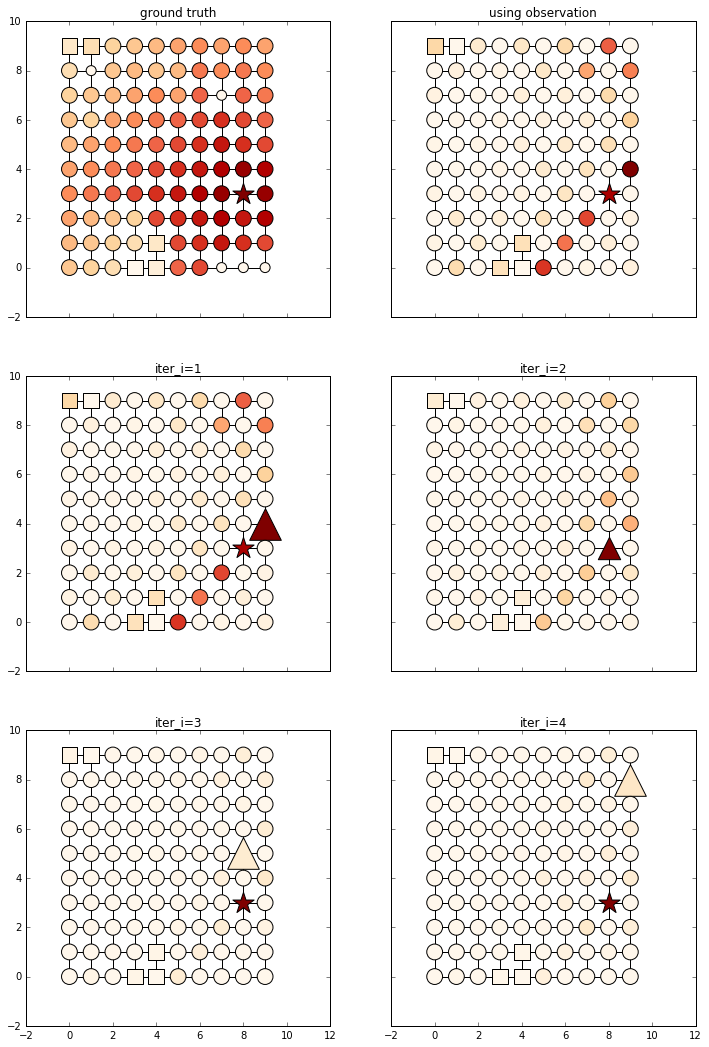

In [29]:
%%timeit -r 1 -n 1
query_count, mu_of_source = mwu(g, source, obs_nodes, infection_times, 
                                times_by_source,
                                source2nodeid_counter,
                                epsilon=0.7,
                                query_selection_method=MAX_MU,
                                inspect_mu=True,
                                debug=False, 
                                plot=True,
                                max_plots=6)

In [30]:
def experiment_multiple_rounds(rounds, g, 
                               times_by_source, 
                               source2nodeid_counter,
                               infp, fraction, epsilon, sampling_method, 
                               query_selection_method,
                               seed=None):
    np.random.seed(seed)
    random.seed(seed)
    results = []
    for i in tqdm(range(rounds)):
        source, obs_nodes, infection_times, tree = make_input(g, infp, fraction, sampling_method=sampling_method)
        r = mwu(g, source, obs_nodes, infection_times, 
                times_by_source, source2nodeid_counter,
                epsilon,
               query_selection_method=query_selection_method)
        results.append(r)
    return results

In [12]:
rounds = 500
infp = 0.7
fraction = 0.05
epsilon = 0.8
sampling_method = 'late_nodes'
params = {
    'infp': infp,
    'fraction': fraction,
    'sampling_method': sampling_method
}

In [34]:
results_by_query_method = {}
for method in [MIN_CONSENSUS,MAX_MU,  RANDOM]:
    result = experiment_multiple_rounds(rounds, g, 
                                        times_by_source, source2nodeid_counter, 
                                        infp, fraction, epsilon, sampling_method,
                                        query_selection_method=method,
                                        seed=123456)
    cnts, mu_lists = zip(*result)
    s = pd.Series(cnts)
    results_by_query_method[method] = s.describe().to_dict()
result = pd.DataFrame.from_dict(results_by_query_method)    

100%|██████████| 500/500 [00:14<00:00, 33.90it/s]


In [36]:
result

,max_mu,min_consensus,random
25%,6.000000,6.000000,9.000000
50%,9.000000,10.000000,16.000000
75%,12.000000,16.000000,37.500000
count,500.000000,500.000000,500.000000
max,95.000000,99.000000,99.000000
mean,11.712000,16.706000,32.152000
min,3.000000,3.000000,3.000000
std,13.978263,21.329638,33.478808


In [37]:
print(result.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &      max\_mu &  min\_consensus &      random \\
\midrule
25\%   &    6.000000 &       6.000000 &    9.000000 \\
50\%   &    9.000000 &      10.000000 &   16.000000 \\
75\%   &   12.000000 &      16.000000 &   37.500000 \\
count &  500.000000 &     500.000000 &  500.000000 \\
max   &   95.000000 &      99.000000 &   99.000000 \\
mean  &   11.712000 &      16.706000 &   32.152000 \\
min   &    3.000000 &       3.000000 &    3.000000 \\
std   &   13.978263 &      21.329638 &   33.478808 \\
\bottomrule
\end{tabular}



In [ ]:
s1.hist(bins=20)

In [ ]:
if False:
    # very weird
    # different results are given
    epsilons = np.linspace(0.1, 0.9, 9)
    # epsilons = [0.8]
    seeds = [np.random.randint(0, 10000) for i in range(len(epsilons))]
    results = Parallel(n_jobs=-1)(
        delayed(experiment_multiple_rounds)(rounds, g, times_by_source,
                                            infp, fraction,
                                            epsilon=eps,
                                            sampling_method=sampling_method,
                                            seed=seed)
        for eps, seed in zip(epsilons, seeds))

In [ ]:
epsilons = np.linspace(0.2, 0.9, 8)
# epsilons = [0.8]
results = []

for eps in tqdm(epsilons):
    result = experiment_multiple_rounds(rounds, g, times_by_source,
                                        infp, fraction,
                                        epsilon=eps,
                                        sampling_method=sampling_method)
    results.append(result)    

In [ ]:
list_cnts = [list(zip(*result))[0] for result in results]
means = list(map(np.mean, list_cnts))
medians = list(map(np.median, list_cnts))
df = pd.DataFrame.from_dict({'eps': epsilons,
                             'mean': means, 
                             'median': medians})
df    

In [13]:
from baselines import baseline_dog_tracker

baseline_cnts = []
for i in range(rounds):
    source, obs_nodes, infection_times, tree = make_input(g, infp, fraction, sampling_method=sampling_method)
    c = baseline_dog_tracker(g, obs_nodes, infection_times)
    baseline_cnts.append(c)

In [14]:
pd.Series(baseline_cnts).describe().to_dict()

{'25%': 21.0,
 '50%': 23.0,
 '75%': 26.0,
 'count': 500.0,
 'max': 48.0,
 'mean': 23.306000000000001,
 'min': 4.0,
 'std': 5.046910600875198}

In [ ]:
print('mean', np.mean(baseline_cnts))
print('median', np.median(baseline_cnts))

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax0, ax1 = axes
df.plot(x='eps', y=['mean'], ax=ax0)
ax0.plot([np.mean(baseline_cnts)] * len(epsilons))
ax0.legend(['multiplicative (max mu strategy)', 'baseline'])
ax0.set_ylim(0, 100)
ax0.set_title('mean')
ax0.set_ylabel('query count')

df.plot(x='eps', y=['median'], ax=axes[1])
ax1.plot([np.median(baseline_cnts)] * len(epsilons))
ax1.legend(['multiplicative (max mu strategy)', 'baseline'])
ax1.set_ylim(0, 100)
ax1.set_title('median')
ax1.set_ylabel('query count')

In [ ]:
fig.savefig('figs/grid-{}-{}.png'.format(sampling_method, fraction))

In [ ]:
df.to_pickle('outputs/mwu-{}-{}.pkl'.format(sampling_method, fraction))
import pickle
pd.Series(baseline_cnts).to_pickle('outputs/dog-{}-{}.pkl'.format(sampling_method, fraction))

In [ ]:
# summarize result
eps = 0.8
sampling_methods = ['uniform', 'late_nodes']
fraction = 0.02
for s in sampling_methods:
    s1 = pd.read_pickle('outputs/mwu-{}-{}.pkl'.format(s, fraction))
    s2_cnts = pd.read_pickle('outputs/dog-{}-{}.pkl'.format(s, fraction))
    print('method', s)
    print('mean', s1[s1['eps'] == 0.8].iloc[0]['mean'], np.mean(s2_cnts))
    print('median', s1[s1['eps'] == 0.8].iloc[0]['median'], np.median(s2_cnts))    
    print()